In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as image
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from libpysal.weights import Queen
import numpy as np

sns.set_style("whitegrid")

In [2]:
cm = gpd.read_file('data/map/base/commune.json')
district = gpd.read_file('data/map/base/district.json')
country = gpd.read_file('data/map/base/vietnam.json')

In [3]:
cm = cm.to_crs(epsg=32648)
district = district.to_crs(epsg=32648)
country.to_crs(epsg=32648)
cm['centroid'] = cm.geometry.centroid
centroids = cm.copy()
centroids.geometry = centroids['centroid']

In [4]:
cm = cm.to_crs(epsg=4326)
district = district.to_crs(epsg=4326)
country = country.to_crs(epsg=4326)
centroids = centroids.to_crs(epsg=4326)

In [6]:
country['is_namdinh'] = country['VARNAME_1'] == 'NamDinh'

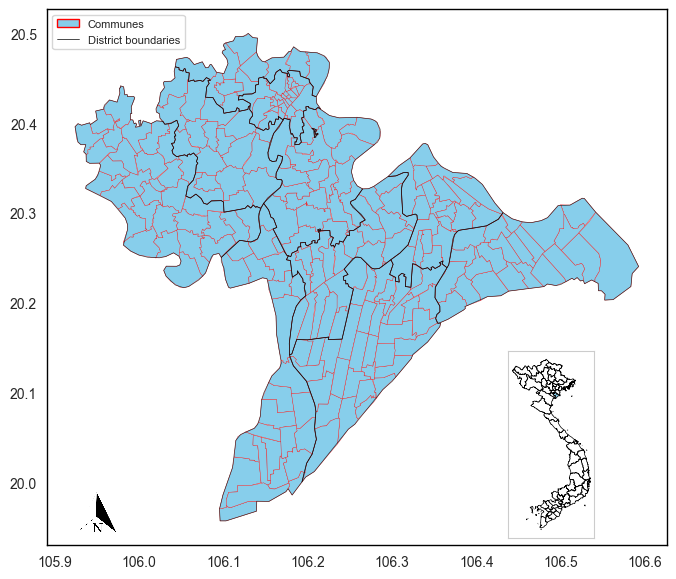

In [10]:
# Set the background color for both the main and inset maps
background_color = 'white'

# Creating the main district and commune map
fig_district, ax_district = plt.subplots(figsize=(8, 8))
ax_district.set_facecolor(background_color)

# Plotting communes with sky blue fill and red edges
cm.plot(ax=ax_district, color='skyblue', edgecolor='red', linewidth=0.25)

# Plotting district boundaries in black
district.plot(ax=ax_district, color='none', edgecolor='black', linewidth=0.5, alpha=0.7)

# Creating the inset map
inset_ax = inset_axes(ax_district, width="35%", height="35%", loc=4)  # Bottom right corner
inset_ax.patch.set_facecolor(background_color)
country.plot(ax=inset_ax, color=background_color, edgecolor='black', linewidth=0.5)
country[country['is_namdinh']].plot(ax=inset_ax, color='skyblue', edgecolor='black', linewidth=0.5)
# centroids.plot(ax=ax_district, marker='o', color='red', markersize=5)
inset_ax.set_xticks([])
inset_ax.set_yticks([])

for spine in ax_district.spines.values():
    spine.set_linewidth(1)  # Making the border lines solid
    spine.set_edgecolor('black')  # Setting the border color to black

for spine in inset_ax.spines.values():
    spine.set_visible(True)  

# Removing gridlines
ax_district.grid(False)
inset_ax.grid(False)

# Custom legend for the map with reduced font size
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='red', label='Communes'),
    Line2D([0], [0], color='black', linewidth=0.5, linestyle='-', label='District boundaries')
]

# Adding the custom legend to the plot with a reduced font size
ax_district.legend(handles=legend_elements, loc='upper left', fontsize=8)
ax_district.ticklabel_format(style='plain', axis='y', useOffset=False)

arrow_img = image.imread('docs/arrow.png')
# Adding the arrow to the bottom left
arrow_position = (0.08, 0.06)  # Adjust as needed
arrowbox = OffsetImage(arrow_img, zoom=0.05)
ab = AnnotationBbox(arrowbox, arrow_position, xycoords='axes fraction', frameon=False)
ax_district.add_artist(ab)
plt.savefig('output_plot.png', dpi=300, bbox_inches='tight')

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_29236\3832389757.py:5: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = Queen.from_dataframe(cm)


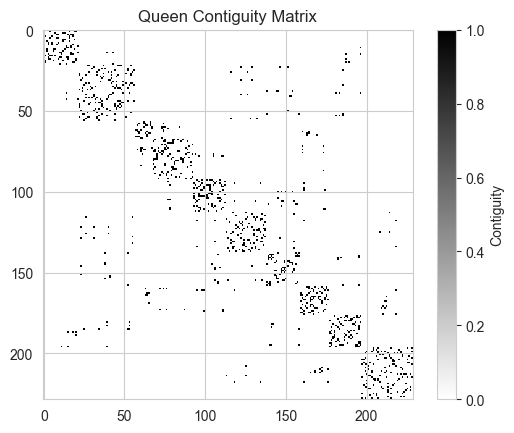

In [17]:


# Assuming 'cm' is your GeoDataFrame
wq = Queen.from_dataframe(cm)

# Plot the matrix as a heatmap
plt.imshow(wq.full()[0], cmap='binary', interpolation='nearest')
plt.title('Queen Contiguity Matrix')
plt.colorbar(label='Contiguity')
plt.show()

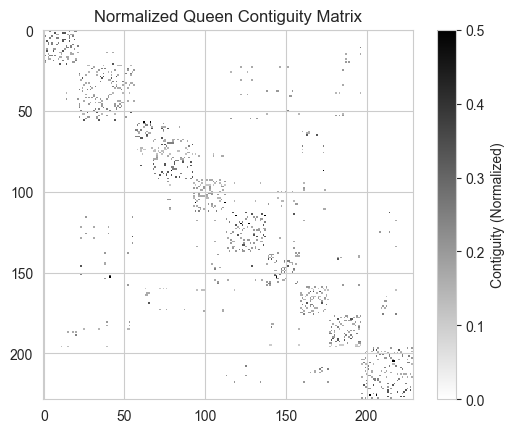

In [19]:

# Convert the queen contiguity matrix to a numpy array
queen_matrix = wq.full()[0]

# Normalize the matrix using row-standardization
row_sums = queen_matrix.sum(axis=1)
normalized_matrix = queen_matrix / row_sums[:, np.newaxis]

# Plot the normalized matrix as a heatmap
plt.imshow(normalized_matrix, cmap='binary', interpolation='nearest')
plt.title('Normalized Queen Contiguity Matrix')
plt.colorbar(label='Contiguity (Normalized)')
plt.show()